In [162]:
import os
import re
import sys
import csv
import time
import tqdm
import nltk
import math
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.corpus import wordnet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.feature_selection import chi2
from scipy.stats import uniform
from scipy.stats import randint
from spellchecker import SpellChecker #need to install for some computers
from Test import * 


feature_names = []

vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words='english',norm='l2',sublinear_tf=False)
#vectorizer = CountVectorizer(ngram_range=(1,1),stop_words='english',binary=True)

corpus_train = pd.read_csv("reddit_train.csv",usecols=['comments','subreddits'],delimiter=',')
corpus_test = pd.read_csv("reddit_test.csv",usecols=['comments'],delimiter=',')
english_words = set(nltk.corpus.words.words()\
                    + nltk.corpus.gutenberg.words()\
                    + nltk.corpus.webtext.words()\
                    + nltk.corpus.nps_chat.words()\
                    + nltk.corpus.brown.words() + nltk.corpus.reuters.words())

#spell = SpellChecker()

# def is_english_word(x):
#     return (spell.correction(x) in english_words)

# important for cleaning non-english tokens
#spell = SpellChecker()
# delete_list = ["aaa" ,"bbb","ccc","ddd","eee","fff","ggg","hhh","iii","jjj","kkk","lll","mmm","nnn","ooo","ppp","qqq","rrr","sss","ttt"\
#                ,"uuu","vvv","www","xxx","yyy","zzz"]

                    
def misspell(x):
    if "aaa" not in x and "bbb" not in x and "ccc" not in x and "ddd" not in x \
    and "eee" not in x and "fff" not in x and "ggg" not in x and "hhh" not in x \
    and "iii" not in x and "jjj" not in x and "kkk" not in x and "lll" not in x and "mmm" not in x and "nnn" not in x \
    and "ooo" not in x and "ppp" not in x and "qqq" not in x and "rrr" not in x and "sss" not in x and "ttt" not in x \
    and "uuu" not in x and "vvv" not in x and "www" not in x and "xxx" not in x and "yyy" not in x and "zzz" not in x \
    and "aa" not in x and 'zk' not in x and 'vd' not in x:
        return True
    else:
        return False
    

# delete_list = ["aaa" not in x,"bbb" not in x,"ccc" not in x,"ddd" not in x,"eee" not in x,"fff" not in x,"ggg" not in x,\
#                "hhh" not in x,"iii" not in x,"jjj" not in x,"kkk" not in x,"lll" not in x,"mmm" not in x,"nnn" not in x,\
#                "ooo" not in x,"ppp" not in x,"qqq" not in x,"rrr" not in x,"sss" not in x,"ttt" not in x
#                ,"uuu" not in x,"vvv" not in x,"www" not in x,"xxx" not in x,"yyy" not in x,"zzz" not in x]

# a helper function to process one comment
def preprocess_text(text): 
    text = text.lower().split()
    stops = set(stopwords.words("english"))
#     text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"^https?:\/\/.*[\r\n]*","", text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ',text)
    text = text.split()
    
    # lemmatization
    lemma = nltk.wordnet.WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text]
    
#     # stemming
#     text = [PorterStemmer().stem(word) for word in text]
    
    text_final = []
    
    # clean all non-English words, numbers, and other weirdos, stopwords
    for x in text:
        #x = spell.correction(x)
        if x.isalpha() and x not in stops and len(x)<17 and len(x) > 1 and misspell(x):# and is_english_word(x):
            if len(x)>11:   # param to tune here
                text_final.append(PorterStemmer().stem(x))
            else:
                text_final.append(x)
    
    text = " ".join(text_final)
    return text


# the major function to process the training dataset
# returns (1) a matrix of all training features x (2) a numpy array of y labels
def preprocess():
    df = corpus_train.copy()
    df['comments'] = df['comments'].map(lambda x: preprocess_text(x))
    y_train = df["subreddits"].to_numpy()
    x_train = vectorizer.fit_transform(df['comments'])
    
    print(vectorizer.get_feature_names())
    global feature_names
    feature_names = vectorizer.get_feature_names()
    featname=vectorizer.get_feature_names()
    chi_squared,pval = chi2(x_train, y_train)
    featname = pd.DataFrame(featname)
    chi_2 = pd.DataFrame(chi_squared)
    pval = pd.DataFrame(pval)

    data = pd.concat([featname,chi_2,pval],axis=1)
    data.columns = ["word","chi_squared","pval"]
    data = data.sort_values("pval",axis=0)

    to_delete = list(data.index[15000:])     # 保留10000-15000之间最高
    all_cols = np.arange(x_train.shape[1])
    cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, to_delete)))[0]
    x_train = x_train[:, cols_to_keep]
    return x_train, y_train


# function to process the testing set
# returns the matrix of all testing features
def preprocess_testing():
    df = corpus_test.copy()
    df['comments'] = df['comments'].map(lambda x: preprocess_text(x))
    #y_train = df["subreddits"].to_numpy()
    x_train = vectorizer.fit_transform(df['comments'])
    return x_train
    

In [163]:
x,y = preprocess()
print(x.shape)

print(x)



['ab', 'aba', 'aback', 'abadi', 'abam', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonned', 'abandonware', 'abaya', 'abb', 'abbas', 'abbey', 'abbotsford', 'abbrevi', 'abbreviated', 'abby', 'abc', 'abck', 'abd', 'abdelhak', 'abdelkader', 'abdicate', 'abdomen', 'abdominal', 'abducted', 'abducting', 'abduction', 'abductive', 'abdul', 'abdullah', 'abe', 'abeast', 'abed', 'abel', 'abell', 'abendblatt', 'aberation', 'aberdeen', 'aberg', 'aberration', 'abetting', 'abeyta', 'abgelehnt', 'abgrenzung', 'abhor', 'abhorrent', 'abhors', 'abidal', 'abide', 'abiding', 'abilify', 'abilites', 'abilitie', 'ability', 'abillities', 'abilties', 'abin', 'abingdon', 'abington', 'abit', 'abitur', 'abject', 'ablaze', 'able', 'abled', 'ableton', 'abliged', 'abn', 'abnormal', 'abnormality', 'abnormally', 'aboard', 'abode', 'abogado', 'aboiut', 'abolish', 'abolished', 'abolition', 'abolitionist', 'abolve', 'abominably', 'abomination', 'aboot', 'aboriginal', 'aborigine', 'aborigion', 'abort', 'abort


(70000, 15000)
  (0, 7774)	0.19713257284055197
  (0, 3670)	0.15531399618486355
  (0, 2079)	0.11558811485472645
  (0, 10991)	0.16966892438349518
  (0, 2508)	0.1545863176398273
  (0, 13181)	0.1318513751559542
  (0, 3302)	0.1876220809284455
  (0, 14824)	0.08385167818738551
  (0, 1196)	0.09392451835814869
  (0, 9249)	0.15531399618486355
  (0, 3908)	0.19465232300341145
  (0, 13266)	0.07608839829084921
  (0, 13540)	0.16317427237808252
  (0, 4988)	0.0880005866234226
  (0, 14592)	0.11681489321416656
  (0, 14320)	0.1752338852239153
  (0, 5247)	0.1733010565108391
  (0, 12575)	0.13921682194602888
  (0, 9761)	0.07547707577357769
  (0, 10890)	0.1184257613715212
  (0, 454)	0.13563888693299905
  (0, 2694)	0.13262316352764317
  (0, 1680)	0.5603192906159367
  (0, 5984)	0.12916866550260914
  (1, 1748)	0.34595493716838277
  :	:
  (69998, 7583)	0.1724837462437731
  (69998, 5756)	0.19443845503521032
  (69998, 13226)	0.15064351356004485
  (69998, 10192)	0.18350952840744125
  (69998, 8946)	0.164703373875262

In [164]:
clf = MultinomialNB(alpha=0.0565)
#x,y = preprocess()

model_validate(clf,x,y)



Result of k-fold cross validation on  MultinomialNB
0.5883571428571429


In [121]:
print(feature_names)

['ab', 'aba', 'aback', 'abadi', 'abam', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonned', 'abandonware', 'abaya', 'abb', 'abbas', 'abbey', 'abbotsford', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abck', 'abd', 'abdelhak', 'abdelkader', 'abdicate', 'abdomen', 'abdominal', 'abducted', 'abducting', 'abduction', 'abductive', 'abdul', 'abdullah', 'abe', 'abeast', 'abed', 'abel', 'abell', 'abendblatt', 'aberation', 'aberdeen', 'aberg', 'aberration', 'abetting', 'abeyta', 'abgelehnt', 'abgrenzung', 'abhor', 'abhorrent', 'abhors', 'abidal', 'abide', 'abiding', 'abilify', 'abilites', 'abilitie', 'ability', 'abillities', 'abilties', 'abin', 'abingdon', 'abington', 'abit', 'abitur', 'abject', 'ablaze', 'able', 'abled', 'ableton', 'abliged', 'abn', 'abnormal', 'abnormality', 'abnormally', 'aboard', 'abode', 'abogado', 'aboiut', 'abolish', 'abolished', 'abolition', 'abolitionist', 'abolve', 'abominably', 'abomination', 'aboot', 'aboriginal', 'aborigine', 'aborigionals', 'abort'

'adamantly'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F900438D0>,
      dtype=object)

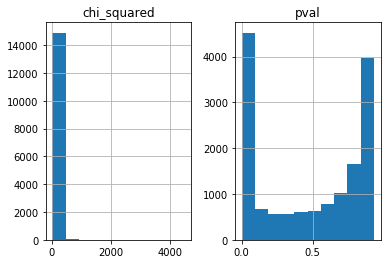

In [122]:
featname=feature_names
chi_squared,pval = chi2(x, y)
featname = pd.DataFrame(featname)
chi_2 = pd.DataFrame(chi_squared)
pval = pd.DataFrame(pval)

data = pd.concat([featname,chi_2,pval],axis=1)
data.columns = ["word","chi_squared","pval"]
#data = data.sort_values("chi_squared",ascending=False,axis=0)
data = data.sort_values("pval",axis=0)
data.hist()


In [123]:
# with pd.option_context('display.max_rows', 1000, 'display.max_columns', None):  # more options can be specified also
#     print(data)
print(data[:10000].to_string())

                   word  chi_squared           pval
12458           density  3116.198989   0.000000e+00
428             adapter  2622.615362   0.000000e+00
8693               clam  3100.897062   0.000000e+00
275            accurate  1717.431986   0.000000e+00
12316          deluding  2021.966389   0.000000e+00
8769     claustrophobia  4505.296676   0.000000e+00
6773               buut  1636.298645   0.000000e+00
5000         blackberry  2086.152009   0.000000e+00
4567          berkshire  1452.022806  8.785523e-297
1837              annie  1391.535700  8.346927e-284
7455               caso  1234.130997  4.561164e-250
946                 air  1220.301080  4.175144e-247
5515          bombshell  1162.442125  1.012920e-234
12210      dehumanizing  1113.177925  3.496127e-224
9512             comped  1112.583942  4.683843e-224
14463             druds  1100.268217  2.013318e-221
1839         annihilate  1037.799401  4.502757e-208
8328         chisenhall  1017.290866  1.079730e-203
5518        

5308            blunder    13.982228   7.847263e-01


In [51]:
to_delete= list(data.index[15000:])     # 保留10000-15000之间最高



all_cols = np.arange(x.shape[1])
cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, to_delete)))[0]
x_train = x[:, cols_to_keep]

In [59]:
clf = MultinomialNB(alpha=0.0565)
#x,y = preprocess()

model_validate(clf,x_train,y)


Result of k-fold cross validation on  MultinomialNB
0.5801571428571429


In [ ]:
featname=feature_names
chi_squared,pval = chi2(x, y)
featname = pd.DataFrame(featname)
chi_2 = pd.DataFrame(chi_squared)
pval = pd.DataFrame(pval)

data = pd.concat([featname,chi_2,pval],axis=1)
data.columns = ["word","chi_squared","pval"]
data = data.sort_values("pval",axis=0)

to_delete_probable = list(data.index[10000:])     # 保留10000-15000之间最高
to_delete=[]


from tqdm import tqdm
#suspicious_word_index = []
spell = SpellChecker()
for i in tqdm(to_delete_probable):
    if spell.correction(feature_names[i]) not in english_words:
        to_delete.append(i)








  0%|                                                                                        | 0/47430 [00:00<?, ?it/s]


  0%|                                                                              | 3/47430 [00:01<8:38:57,  1.52it/s]


  0%|                                                                             | 12/47430 [00:04<7:05:10,  1.86it/s]


  0%|                                                                             | 19/47430 [00:05<5:41:05,  2.32it/s]


  0%|                                                                            | 20/47430 [00:09<19:13:16,  1.46s/it]


  0%|                                                                            | 23/47430 [00:10<15:10:37,  1.15s/it]


  0%|                                                                            | 24/47430 [00:12<17:08:05,  1.30s/it]


  0%|                                                                            | 26/47430 [00:13<14:00:15,  1.06s/it]


  0%|                

In [ ]:

all_cols = np.arange(x_train.shape[1])
cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, to_delete)))[0]
x_train = x[:, cols_to_keep]

In [4]:
from tqdm import tqdm

index_to_delete = []
index_to_combine = []


for i in tqdm(range(len(feature_names)-1)):
    same_root = [i]
    for j in range(i+1,len(feature_names)):
        if(feature_names[i][0]!=feature_names[j][0]):
            break
        else:
            if PorterStemmer().stem(feature_names[i]) == PorterStemmer().stem(feature_names[j]):
                same_root.append(j)

    index_to_combine.append(same_root)




# from spellchecker import SpellChecker
# spell = SpellChecker()

# wrong_word_index_list = []
# for i in tqdm(range(len(feature_names))):
#     if len(feature_names[i])<=10:
#         if (spell.correction(feature_names[i]) not in english_words):
#             wrong_word_index_list.append(i)

# print(wrong_word_index_list)





100%|██████████████████████████████████████████████████████████████████████████| 57429/57429 [1:07:15<00:00, 14.23it/s]


In [5]:
#print(index_to_combine)
#index_to_combine_plus = [line for line in index_to_combine if len(line)>2]
filtered_lines = list(filter(lambda x: len(x) > 1, index_to_combine))
to_delete_index = []
for i in range(len(filtered_lines)-1):
    for j in range(i+1,min(len(filtered_lines),i+10)):
        if set(filtered_lines[j]) <= set(filtered_lines[i]):
            to_delete_index.append(j)
    

In [6]:
filtered_lines

[[4, 5, 6, 7, 8],
 [5, 6, 7, 8],
 [6, 7, 8],
 [7, 8],
 [15, 16],
 [26, 27, 28, 29],
 [27, 28, 29],
 [28, 29],
 [32, 34],
 [35, 36],
 [46, 48],
 [49, 50, 51],
 [50, 51],
 [55, 56],
 [65, 66],
 [70, 71, 72],
 [71, 72],
 [77, 78],
 [82, 83],
 [85, 86],
 [88, 89, 90, 91],
 [89, 90, 91],
 [90, 91],
 [100, 101],
 [108, 109],
 [120, 121, 122, 123],
 [121, 122, 123],
 [122, 123],
 [128, 129, 130, 131],
 [129, 130, 131],
 [130, 131],
 [132, 133],
 [135, 136],
 [139, 140],
 [145, 147],
 [153, 155],
 [156, 157],
 [159, 160, 161, 162, 163, 164],
 [160, 161, 162, 163, 164],
 [161, 162, 163, 164],
 [162, 163, 164],
 [163, 164],
 [165, 166],
 [169, 170],
 [172, 174, 177],
 [174, 177],
 [175, 176],
 [183, 205],
 [187, 188, 189, 190, 191],
 [188, 189, 190, 191],
 [189, 190, 191],
 [190, 191],
 [192, 193, 194],
 [193, 194],
 [195, 196],
 [197, 198, 199, 200, 201, 203, 204],
 [198, 199, 200, 201, 203, 204],
 [199, 200, 201, 203, 204],
 [200, 201, 203, 204],
 [201, 203, 204],
 [203, 204],
 [206, 207],
 [2

In [7]:

len(filtered_lines) - len(set(to_delete_index))

6994

In [8]:
new_line = []
main_cols = []
for i in range(len(filtered_lines)):
    if i not in set(to_delete_index):
        new_line.append(filtered_lines[i])
        main_cols.append(filtered_lines[i][0])

In [9]:
new_line

[[4, 5, 6, 7, 8],
 [15, 16],
 [26, 27, 28, 29],
 [32, 34],
 [35, 36],
 [46, 48],
 [49, 50, 51],
 [55, 56],
 [65, 66],
 [70, 71, 72],
 [77, 78],
 [82, 83],
 [85, 86],
 [88, 89, 90, 91],
 [100, 101],
 [108, 109],
 [120, 121, 122, 123],
 [128, 129, 130, 131],
 [132, 133],
 [135, 136],
 [139, 140],
 [145, 147],
 [153, 155],
 [156, 157],
 [159, 160, 161, 162, 163, 164],
 [165, 166],
 [169, 170],
 [172, 174, 177],
 [175, 176],
 [183, 205],
 [187, 188, 189, 190, 191],
 [192, 193, 194],
 [195, 196],
 [197, 198, 199, 200, 201, 203, 204],
 [206, 207],
 [209, 210, 211, 212, 213, 214],
 [216, 219],
 [217, 218],
 [221, 222],
 [225, 226, 227, 228],
 [229, 230],
 [231, 232, 233, 234, 235],
 [238, 239, 240, 241, 242],
 [243, 244, 245, 247],
 [251, 252, 253, 254, 255, 256],
 [260, 261, 262],
 [263, 264],
 [267, 268, 269, 270, 271],
 [273, 274],
 [277, 280, 281, 282, 283, 284],
 [294, 297, 309],
 [301, 302, 303, 304, 305, 306, 307],
 [310, 317],
 [318, 319, 321],
 [323, 324, 325, 326, 327],
 [330, 332],

In [10]:
new_line #######
x,y = preprocess()

['aba', 'aback', 'abadi', 'abam', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonned', 'abandonware', 'abaya', 'abb', 'abbas', 'abbey', 'abbotsford', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abck', 'abd', 'abdelhak', 'abdelkader', 'abdicate', 'abdomen', 'abdominal', 'abducted', 'abducting', 'abduction', 'abductive', 'abdul', 'abdullah', 'abe', 'abeast', 'abed', 'abel', 'abell', 'abendblatt', 'aberation', 'aberdeen', 'aberg', 'aberration', 'abetting', 'abeyta', 'abgelehnt', 'abgrenzung', 'abhor', 'abhorrent', 'abhors', 'abidal', 'abide', 'abiding', 'abilify', 'abilites', 'abilitie', 'ability', 'abillities', 'abilties', 'abin', 'abingdon', 'abington', 'abit', 'abitur', 'abject', 'ablaze', 'able', 'abled', 'ableton', 'abliged', 'abn', 'abnormal', 'abnormality', 'abnormally', 'aboard', 'abode', 'abogado', 'aboiut', 'abolish', 'abolished', 'abolition', 'abolitionist', 'abolve', 'abominably', 'abomination', 'aboot', 'aboriginal', 'aborigine', 'aborigionals', 'abort', 'abo

In [23]:
temp = x

In [24]:
from scipy.sparse import csr_matrix
#len(temp[:,2666].toarray())
#temp[:,4] = csr_matrix(temp[:,4].toarray()+temp[:,4].toarray())


In [26]:
from tqdm import tqdm
for i in tqdm(range(len(new_line)-1)):
    temp[:,new_line[i][0]] = csr_matrix(temp[:,new_line[i][0]].toarray() * len(new_line[i]))



  0%|                                                                                         | 0/6993 [00:00<?, ?it/s]

  0%|▏                                                                              | 14/6993 [00:00<00:51, 135.70it/s]

  0%|▎                                                                              | 28/6993 [00:00<00:51, 135.12it/s]

  1%|▍                                                                              | 42/6993 [00:00<00:51, 135.68it/s]

  1%|▌                                                                              | 55/6993 [00:00<00:52, 132.83it/s]

  1%|▊                                                                              | 69/6993 [00:00<00:52, 132.73it/s]

  1%|▉                                                                              | 82/6993 [00:00<00:52, 131.23it/s]

  1%|█                                                                              | 96/6993 [00:00<00:52, 131.61it/s]

  2%|█▏                       

 22%|█████████████████▏                                                            | 1539/6993 [00:14<00:58, 93.80it/s]

 22%|█████████████████▎                                                            | 1549/6993 [00:14<00:58, 93.66it/s]

 22%|█████████████████▍                                                            | 1559/6993 [00:14<00:58, 93.44it/s]

 22%|█████████████████▌                                                            | 1569/6993 [00:14<01:00, 90.39it/s]

 23%|█████████████████▌                                                            | 1579/6993 [00:14<00:58, 92.39it/s]

 23%|█████████████████▋                                                            | 1589/6993 [00:15<00:58, 92.93it/s]

 23%|█████████████████▊                                                            | 1599/6993 [00:15<01:01, 88.05it/s]

 23%|█████████████████▉                                                            | 1608/6993 [00:15<01:01, 87.80it/s]

 23%|██████████████████         

 39%|██████████████████████████████▎                                               | 2719/6993 [00:29<00:58, 73.01it/s]

 39%|██████████████████████████████▍                                               | 2727/6993 [00:29<00:58, 73.20it/s]

 39%|██████████████████████████████▌                                               | 2735/6993 [00:29<00:57, 74.04it/s]

 39%|██████████████████████████████▌                                               | 2743/6993 [00:29<00:57, 73.82it/s]

 39%|██████████████████████████████▋                                               | 2751/6993 [00:29<00:58, 72.67it/s]

 39%|██████████████████████████████▊                                               | 2759/6993 [00:29<00:57, 73.06it/s]

 40%|██████████████████████████████▊                                               | 2767/6993 [00:29<00:59, 71.58it/s]

 40%|██████████████████████████████▉                                               | 2775/6993 [00:29<00:59, 70.67it/s]

 40%|███████████████████████████

 53%|█████████████████████████████████████████▎                                    | 3699/6993 [00:43<00:49, 66.06it/s]

 53%|█████████████████████████████████████████▎                                    | 3706/6993 [00:43<00:49, 66.77it/s]

 53%|█████████████████████████████████████████▍                                    | 3713/6993 [00:43<00:48, 67.19it/s]

 53%|█████████████████████████████████████████▍                                    | 3720/6993 [00:43<00:48, 67.00it/s]

 53%|█████████████████████████████████████████▌                                    | 3727/6993 [00:43<00:48, 67.74it/s]

 53%|█████████████████████████████████████████▋                                    | 3734/6993 [00:44<00:48, 67.77it/s]

 53%|█████████████████████████████████████████▋                                    | 3741/6993 [00:44<00:48, 67.60it/s]

 54%|█████████████████████████████████████████▊                                    | 3748/6993 [00:44<00:48, 67.10it/s]

 54%|███████████████████████████

 68%|████████████████████████████████████████████████████▊                         | 4737/6993 [00:58<00:28, 78.17it/s]

 68%|████████████████████████████████████████████████████▉                         | 4745/6993 [00:58<00:28, 77.87it/s]

 68%|█████████████████████████████████████████████████████                         | 4753/6993 [00:58<00:29, 77.10it/s]

 68%|█████████████████████████████████████████████████████                         | 4762/6993 [00:58<00:28, 78.13it/s]

 68%|█████████████████████████████████████████████████████▏                        | 4770/6993 [00:58<00:28, 77.73it/s]

 68%|█████████████████████████████████████████████████████▎                        | 4778/6993 [00:58<00:28, 77.67it/s]

 68%|█████████████████████████████████████████████████████▍                        | 4786/6993 [00:58<00:28, 78.31it/s]

 69%|█████████████████████████████████████████████████████▍                        | 4794/6993 [00:58<00:27, 78.65it/s]

 69%|███████████████████████████

 85%|██████████████████████████████████████████████████████████████████            | 5928/6993 [01:12<00:12, 84.47it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 5938/6993 [01:12<00:12, 86.61it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 5947/6993 [01:13<00:11, 87.42it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 5956/6993 [01:13<00:12, 85.51it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 5965/6993 [01:13<00:12, 85.18it/s]

 85%|██████████████████████████████████████████████████████████████████▋           | 5974/6993 [01:13<00:12, 84.58it/s]

 86%|██████████████████████████████████████████████████████████████████▋           | 5984/6993 [01:13<00:11, 86.14it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 5993/6993 [01:13<00:11, 84.89it/s]

 86%|███████████████████████████

In [27]:
to_delete_from_matrix=[]
for i in range(len(new_line)):
    for j in range(1,len(new_line[i])):
        to_delete_from_matrix.append(new_line[i][j])
to_delete_from_matrix= list(set(to_delete_from_matrix))

In [28]:
to_delete = to_delete_from_matrix
all_cols = np.arange(temp.shape[1])
cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, to_delete)))[0]
temp = temp[:, cols_to_keep]

In [29]:
temp.shape

(70000, 45018)

In [33]:
print(len(main_cols))

6994


In [34]:
from sklearn.preprocessing import normalize
temp2 = normalize(temp,axis=1)

In [35]:
clf = MultinomialNB(alpha=0.0565)
#x,y = preprocess()

model_validate(clf,temp2,y)

Result of k-fold cross validation on  MultinomialNB
0.4842857142857143


In [31]:
x,y = preprocess()
clf = MultinomialNB(alpha=0.0565)
#x,y = preprocess()

model_validate(clf,x,y)

['aba', 'aback', 'abadi', 'abam', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonned', 'abandonware', 'abaya', 'abb', 'abbas', 'abbey', 'abbotsford', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abck', 'abd', 'abdelhak', 'abdelkader', 'abdicate', 'abdomen', 'abdominal', 'abducted', 'abducting', 'abduction', 'abductive', 'abdul', 'abdullah', 'abe', 'abeast', 'abed', 'abel', 'abell', 'abendblatt', 'aberation', 'aberdeen', 'aberg', 'aberration', 'abetting', 'abeyta', 'abgelehnt', 'abgrenzung', 'abhor', 'abhorrent', 'abhors', 'abidal', 'abide', 'abiding', 'abilify', 'abilites', 'abilitie', 'ability', 'abillities', 'abilties', 'abin', 'abingdon', 'abington', 'abit', 'abitur', 'abject', 'ablaze', 'able', 'abled', 'ableton', 'abliged', 'abn', 'abnormal', 'abnormality', 'abnormally', 'aboard', 'abode', 'abogado', 'aboiut', 'abolish', 'abolished', 'abolition', 'abolitionist', 'abolve', 'abominably', 'abomination', 'aboot', 'aboriginal', 'aborigine', 'aborigionals', 'abort', 'abo


Result of k-fold cross validation on  MultinomialNB
0.5519142857142857


In [142]:
for i in tqdm(range(len(new_line))):
    for j in range(1,len(new_line[i])):
        temp[:,new_line[i][0]] = csr_matrix(temp[:,new_line[i][j]].toarray() + temp[:,new_line[i][0]].toarray())





  0%|                                                                                         | 0/6994 [00:00<?, ?it/s]

ValueError: indices and data should have the same size

In [117]:
temp[:,0].toarray()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [98]:
set([1,2]) <= set([1,2,3])

True

In [67]:
#print(index_to_combine)
x,y = preprocess()

print(x)




['aba', 'aback', 'abadi', 'abam', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonned', 'abandonware', 'abaya', 'abb', 'abbas', 'abbey', 'abbotsford', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abck', 'abd', 'abdelhak', 'abdelkader', 'abdicate', 'abdomen', 'abdominal', 'abducted', 'abducting', 'abduction', 'abductive', 'abdul', 'abdullah', 'abe', 'abeast', 'abed', 'abel', 'abell', 'abendblatt', 'aberation', 'aberdeen', 'aberg', 'aberration', 'abetting', 'abeyta', 'abgelehnt', 'abgrenzung', 'abhor', 'abhorrent', 'abhors', 'abidal', 'abide', 'abiding', 'abilify', 'abilites', 'abilitie', 'ability', 'abillities', 'abilties', 'abin', 'abingdon', 'abington', 'abit', 'abitur', 'abject', 'ablaze', 'able', 'abled', 'ableton', 'abliged', 'abn', 'abnormal', 'abnormality', 'abnormally', 'aboard', 'abode', 'abogado', 'aboiut', 'abolish', 'abolished', 'abolition', 'abolitionist', 'abolve', 'abominably', 'abomination', 'aboot', 'aboriginal', 'aborigine', 'aborigionals', 'abort', 'abo


  (0, 29360)	0.20022594191910897
  (0, 14190)	0.15775115563721837
  (0, 7907)	0.11740190288167779
  (0, 42071)	0.1723313388019609
  (0, 9505)	0.15701205849058875
  (0, 50247)	0.13392036335509133
  (0, 12684)	0.19056621306873878
  (0, 49501)	0.23458446228031543
  (0, 56743)	0.08516746372577937
  (0, 4649)	0.09539836510311284
  (0, 51767)	0.22717098530336569
  (0, 35021)	0.15775115563721837
  (0, 14997)	0.1977067724450827
  (0, 50637)	0.07728236382946274
  (0, 51539)	0.16573477387875873
  (0, 19417)	0.08938147609101936
  (0, 55951)	0.11864793162774175
  (0, 20369)	0.1760204656970901
  (0, 47897)	0.14140138741898675
  (0, 30242)	0.2412815872074171
  (0, 26124)	0.18691498233158588
  (0, 46893)	0.16558409629962711
  (0, 37128)	0.07666144854857686
  (0, 41636)	0.12030554299058105
  (0, 1888)	0.13776730808959703
  :	:
  (69998, 28745)	0.17320360534707682
  (69998, 22108)	0.19524994188505868
  (69998, 50407)	0.15127222268163704
  (69998, 38849)	0.18427540349679816
  (69998, 33754)	0.165390761

MemoryError: 

In [36]:
all_cols = np.arange(x.shape[1])
cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, wrong_word_index_list)))[0]
x = x[:, cols_to_keep]

In [37]:
print(x.shape)

(70000, 40956)


In [38]:
clf = MultinomialNB(alpha=0.0565)
#x,y = preprocess()

model_validate(clf,x,y)

Result of k-fold cross validation on  MultinomialNB
0.49660000000000004


In [33]:
x,y = preprocess()
featname=vectorizer.get_feature_names()
#print(len(featname))
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.feature_selection import chi2

chi2,pval = chi2(x, y)
featname = pd.DataFrame(featname)
chi2 = pd.DataFrame(chi2)
pval = pd.DataFrame(pval)

data=pd.concat([featname,chi2,pval],axis=1)
data.columns = ["word","chi2","pval"]
data=data.sort_values("pval",axis=0)

to_delete = list(data.index[10000:])     # 保留10000-15000之间最高

all_cols = np.arange(x.shape[1])
cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, to_delete)))[0]
m = x[:, cols_to_keep]

clf = MultinomialNB(alpha=0.15,fit_prior=True)

model_validate(clf,m,y)



KeyboardInterrupt: 

In [119]:
type(x)

scipy.sparse.csr.csr_matrix

In [120]:
print(x.shape)

(70000, 58846)


In [121]:
# import scipy
# def delete_rows_csr(mat, indices):
#     """
#     Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
#     """
#     if not isinstance(mat, scipy.sparse.csr_matrix):
#         raise ValueError("works only for CSR format -- use .tocsr() first")
#     #indices = list(indices)
#     mask = np.ones(mat.shape, dtype=bool)
#     mask[:,indices] = False
#     return mat[mask]

to_delete = list(data.index[10000:])     # 保留10000-15000之间最高

all_cols = np.arange(x.shape[1])
cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, to_delete)))[0]
m = x[:, cols_to_keep]

In [122]:
#print(data['pval'])

#print(sorted(x,reverse=True))
print(m.shape)



#clf = LogisticRegression()
from sklearn.svm import SVC
#clf = SVC(gamma='auto')
clf = MultinomialNB(alpha=0.15,fit_prior=False)

(70000, 10000)


In [123]:
model_validate(clf,m,y)

Result of k-fold cross validation on  MultinomialNB
0.5860285714285715


In [106]:
print(new_x.shape)

NameError: name 'new_x' is not defined

In [73]:
# print(type(x))
# print(x)
matrix = np.asmatrix(x)
print(matrix)

[[<70000x59109 sparse matrix of type '<class 'numpy.float64'>'
	with 1169985 stored elements in Compressed Sparse Row format>]]


In [ ]:
x,y = preprocess()
print(x.shape)
y2 = preprocess_testing()
print(y2.shape)

In [175]:
print(vectorizer.get_feature_names())

  (0, 22632)	1
  (0, 6394)	3
  (0, 25040)	1
  (0, 49543)	5
  (0, 10205)	1
  (0, 1908)	1
  (0, 40958)	1
  (0, 36519)	1
  (0, 25734)	1
  (0, 49523)	1
  (0, 29720)	1
  (0, 18126)	3
  (0, 47055)	1
  (0, 20038)	1
  (0, 53925)	3
  (0, 19121)	1
  (0, 19628)	1
  (0, 49755)	1
  (0, 14772)	1
  (0, 18629)	1
  (0, 34423)	1
  (0, 50873)	1
  (0, 4620)	1
  (0, 36054)	1
  (0, 34386)	2
  (0, 55815)	1
  (0, 6632)	1
  (0, 48625)	1
  (0, 12488)	1
  (0, 49354)	1
  (0, 9358)	1
  (0, 32228)	1
  (0, 31961)	1
  (0, 41375)	1
  (0, 7811)	1
  (0, 50212)	1
  (0, 13961)	1
  (0, 28870)	1
{'movies', 'baseball', 'nba', 'canada', 'hockey', 'Overwatch', 'GlobalOffensive', 'wow', 'gameofthrones', 'worldnews', 'Music', 'funny', 'nfl', 'europe', 'soccer', 'trees', 'AskReddit', 'anime', 'conspiracy', 'leagueoflegends'}


In [152]:
print(vectorizer.get_feature_names())

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaand', 'aaaaaaaaahq', 'aaaaaaaabeq', 'aaaaaaaacxi', 'aaaaaaaaezo', 'aaaaaaaafii', 'aaaaaaaamza', 'aaaaaaaannd', 'aaaaaaaaz', 'aaaaaaabheo', 'aaaaaand', 'aaaaand', 'aaaages', 'aaaah', 'aaaand', 'aaaannnd', 'aaah', 'aaahahaha', 'aaand', 'aaannnd', 'aaawhitney', 'aabb', 'aac', 'aacnjournals', 'aaf', 'aafc', 'aah', 'aahhh', 'aahhhh', 'aaliyah', 'aam', 'aan', 'aang', 'aangechouwen', 'aardman', 'aaron', 'aarp', 'aarya', 'aasaults', 'aat', 'aatrox', 'aau', 'aav', 'aawe', 'ab', 'aba', 'aback', 'abadi', 'abam', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonned', 'abandonware', 'abaya', 'abb', 'abbas', 'abbey', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abck', 'abd', 'abdelhak', 'abdelkader', 'abdicate', 'abdomen', 'abdominal', 'abducted', 'abducting', 'abduction', 'abductive', 'abdul', 'abdullah', 'abe', 'abeast', 'abed', 'abel', 'abell', 'abendblatt', 'aberation', 'aberdeen', 'aberg', 'aberration', 'abetting', 'abeyta', 'a

In [11]:
vectorizer = CountVectorizer()

corpus = [ 'This is a sentence',
           'Another sentence is here',
           'Wait for another sentence',
           'The sentence is coming',
           'The sentence has come'
         ]

x = vectorizer.fit_transform(corpus)
print(pd.DataFrame(x.A, columns=vectorizer.get_feature_names()).to_string())

   another  come  coming  for  has  here  is  sentence  the  this  wait
0        0     0       0    0    0     0   1         1    0     1     0
1        1     0       0    0    0     1   1         1    0     0     0
2        1     0       0    1    0     0   0         1    0     0     1
3        0     0       1    0    0     0   1         1    1     0     0
4        0     1       0    0    1     0   0         1    1     0     0


In [13]:
print(x.A)

[[0 0 0 0 0 0 1 1 0 1 0]
 [1 0 0 0 0 1 1 1 0 0 0]
 [1 0 0 1 0 0 0 1 0 0 1]
 [0 0 1 0 0 0 1 1 1 0 0]
 [0 1 0 0 1 0 0 1 1 0 0]]


In [19]:
from spellchecker import SpellChecker
spell = SpellChecker()
x = spell.correction("admires")
print(x)

admires


In [53]:
PorterStemmer().stem("abandonware")
#PorterStemmer().stem("administration")
# lemma = nltk.wordnet.WordNetLemmatizer()
# lemma.lemmatize("administr")

# x = spell.correction("administr")
# lemma.lemmatize("administer")

'abandonwar'

In [ ]:
#######################Stats memo##########################
No. of tokens: training set / test set

No operation: 62853 / 41462
    
spelling-correction: 
    
remove stopwords: 62721 / 41331
remove non-English: 20713 / 16111
remove non-Englsih/remove stopwords: 20587 / 15986
    
lemma/remove non-English: 21125 / 16518
stem/remove non-English: 10462 / 8352

    
lemma/remove non-English/remove stopwords: 21002 / 16396
stem/remove non-English/remove stopwords: 10359 / 8250

lemma/stem/remove non-English/remove stopwords: 10323 / 8236


    
